Finding the Efficient Frontier using convex
optimization with cvxpy

1. Import the libraries:

In [2]:
!pip install yfinance

import yfinance as yf
import numpy as np
import pandas as pd


     |████████████████████████████████| 6.4 MB 7.3 MB/s 
     |████████████████████████████████| 63 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


2. Set up the parameters:

In [3]:
N_PORTFOLIOS = 10 ** 5
N_DAYS = 252
RISKY_ASSETS = ['FB', 'TSLA', 'TWTR', 'MSFT']
RISKY_ASSETS.sort()
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)

3. Download the stock prices from Yahoo Finance:

In [4]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, end=END_DATE, adjusted=True)

[*********************100%***********************]  4 of 4 completed


4. Calculate annualized average returns and the corresponding standard deviation:

In [5]:
returns_df = prices_df['Adj Close'].pct_change().dropna()
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

5. Simulate random portfolio weights

In [6]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /= np.sum(weights, axis=1)[:, np.newaxis]

6. Calculate the portfolio metrics

In [7]:
portf_rtns = np.dot(weights, avg_returns)
portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T,
                    np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)
portf_sharpe_ratio = portf_rtns / portf_vol

7. Create a DataFrame containing all the data

In [8]:
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                    'volatility': portf_vol,
                                    'sharpe_ratio':
                                    portf_sharpe_ratio})

8. Simulate random portfolio weights:

In [9]:
import matplotlib.pyplot as plt

9. Import the library

In [10]:
!pip install wheel
!pip install cvxpy --user
import scipy.optimize as sco
import cvxpy as cp 

10. Convert the annualized average returns and the covariance matrix to numpy arrays

In [11]:
avg_returns = avg_returns.values
cov_mat = cov_mat.values

11. Set up the optimization problem

In [12]:
weights = cp.Variable(n_assets)
gamma = cp.Parameter(nonneg=True)
portf_rtn_cvx = avg_returns * weights
portf_vol_cvx = cp.quad_form(weights, cov_mat)
objective_function = cp.Maximize(portf_rtn_cvx - gamma * portf_vol_cvx)
problem = cp.Problem(objective_function,[cp.sum(weights) == 1, weights >= 0])

12. Calculate the Efficient Frontier

In [13]:
N_POINTS = 25
portf_rtn_cvx_ef = np.zeros(N_POINTS)
portf_vol_cvx_ef = np.zeros(N_POINTS)
weights_ef = []
gamma_range = np.logspace(-3, 3, num=N_POINTS)
for i in range(N_POINTS):
    gamma.value = gamma_range[i]
    problem.solve()
    portf_vol_cvx_ef[i] = cp.sqrt(portf_vol_cvx).value
    portf_rtn_cvx_ef[i] = portf_rtn_cvx.value
    weights_ef.append(weights.value)

Plot the allocation for different values of the risk-aversion parameter

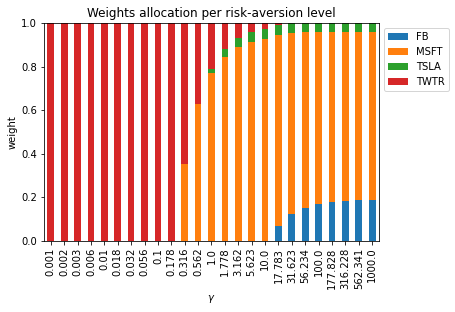

In [14]:
weights_df = pd.DataFrame(weights_ef,
                            columns=RISKY_ASSETS,
                            index=np.round(gamma_range, 3))
ax = weights_df.plot(kind='bar', stacked=True)
ax.set(title='Weights allocation per risk-aversion level',
        xlabel=r'$\gamma$',
        ylabel='weight')
ax.legend(bbox_to_anchor=(1,1))

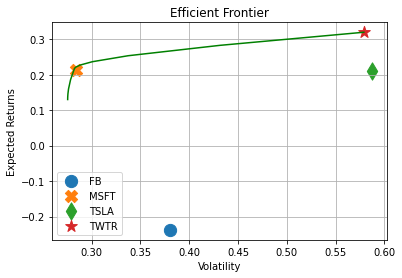

In [15]:
MARKS = ['o', 'X', 'd', '*']

fig, ax = plt.subplots()
ax.plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-')
for asset_index in range(n_assets):
    plt.scatter(x=np.sqrt(cov_mat[asset_index, asset_index]),
                y=avg_returns[asset_index],
                marker=MARKS[asset_index],
                label=RISKY_ASSETS[asset_index],
                s=150)
ax.set(title='Efficient Frontier',
        xlabel='Volatility',
        ylabel='Expected Returns', )
ax.legend()
ax.grid(True)

5. Define functions for calculating portfolio returns and volatility

6. Define the function calculating the Efficient Frontier

In [16]:
def get_portf_rtn(w, avg_rtns):
  return np.sum(avg_rtns * w)
def get_portf_vol(w, avg_rtns, cov_mat):
  return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

In [17]:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
    efficient_portfolios = []
    n_assets = len(avg_returns)
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets, ]
    for ret in rtns_range:
        constraints = ({'type': 'eq',
                    'fun': lambda x: get_portf_rtn(x, avg_rtns)
                    - ret},
                    {'type': 'eq',
                    'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol,
                    initial_guess,
                    args=args,
                    method='SLSQP',
                    constraints=constraints,
                    bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    return efficient_portfolios

7. Define the considered range of returns

In [18]:
rtns_range = np.linspace(-0.22, 0.32, 200)

8. Calculate the Efficient Frontier

In [19]:
efficient_portfolios = get_efficient_frontier(avg_returns,
cov_mat,
rtns_range)

9. Extract the volatilities of the efficient portfolios

In [20]:
vols_range = [x['fun'] for x in efficient_portfolios]

10. Plot the calculated Efficient Frontier, together with the simulated portfolios

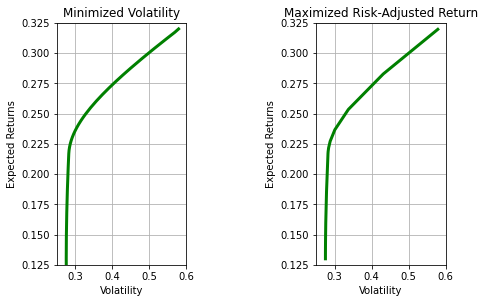

In [21]:
x_lim = [0.25, 0.6]
y_lim = [0.125, 0.325]
fig, ax = plt.subplots(1, 2)

ax[0].plot(vols_range, rtns_range, 'g-', linewidth=3)
ax[0].set(title='Minimized Volatility',
            xlabel='Volatility',
            ylabel='Expected Returns',
            xlim=x_lim,
            ylim=y_lim)
ax[0].grid(True)

ax[1].plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-', linewidth=3)
ax[1].set(title='Maximized Risk-Adjusted Return',
            xlabel='Volatility',
            ylabel='Expected Returns',
            xlim=x_lim,
            ylim=y_lim)
ax[1].grid(True)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=1, hspace=0.25,
                    wspace=1)

plt.show()

In [22]:
max_leverage = cp.Parameter()
problem_with_leverage = cp.Problem(objective_function,
                                    [cp.sum(weights) == 1,
                                    cp.norm(weights, 1) <= max_leverage])

In [23]:
LEVERAGE_RANGE = [1, 2, 5]
len_leverage = len(LEVERAGE_RANGE)
N_POINTS = 25
portf_vol_l_ef = np.zeros((N_POINTS, len_leverage))
portf_rtn_l_ef = np.zeros(( N_POINTS, len_leverage))
weights_ef = np.zeros((len_leverage, N_POINTS, n_assets))
for lev_ind, leverage in enumerate(LEVERAGE_RANGE):
    for gamma_ind in range(N_POINTS):
        max_leverage.value = leverage
        gamma.value = gamma_range[gamma_ind]
        problem_with_leverage.solve()
        portf_vol_l_ef[gamma_ind, lev_ind] = cp.sqrt(portf_vol_cvx).value
        portf_rtn_l_ef[gamma_ind, lev_ind] = portf_rtn_cvx.value
        weights_ef[lev_ind, gamma_ind, :] = weights.value

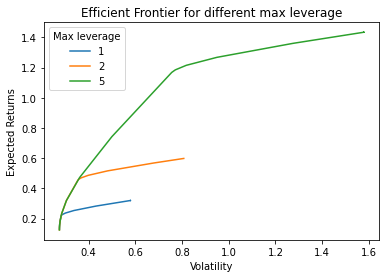

In [24]:
fig, ax = plt.subplots()
for leverage_index, leverage in enumerate(LEVERAGE_RANGE):
    plt.plot(portf_vol_l_ef[:, leverage_index],
        portf_rtn_l_ef[:, leverage_index],
        label=f'{leverage}')
ax.set(title='Efficient Frontier for different max leverage',
        xlabel='Volatility',
        ylabel='Expected Returns')
ax.legend(title='Max leverage');

Text(0.5, 1.0, 'Weights allocation per risk-aversion level')

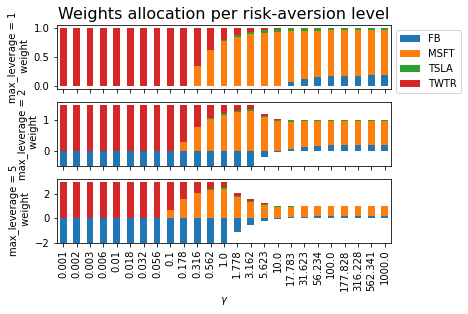

In [25]:
fig, ax = plt.subplots(len_leverage, 1, sharex=True)
for ax_index in range(len_leverage):
    weights_df = pd.DataFrame(weights_ef[ax_index],
                            columns=RISKY_ASSETS,
                            index=np.round(gamma_range, 3))
    weights_df.plot(kind='bar',
                    stacked=True,
                    ax=ax[ax_index],
                    legend=None)
    ax[ax_index].set(ylabel=(f'max_leverage = {LEVERAGE_RANGE[ax_index]}'
                    '\n weight'))
ax[len_leverage - 1].set(xlabel=r'$\gamma$')
ax[0].legend(bbox_to_anchor=(1,1))
ax[0].set_title('Weights allocation per risk-aversion level',
                fontsize=16)